In [1]:
# =========================
# 1. IMPORT LIBRARIES
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib


In [8]:
# =========================
# 2. LOAD DATA
# =========================
data = pd.read_csv(r"..\data\FuelConsumption.csv")


In [3]:
# =========================
# 3. BASIC EDA
# =========================
print("Shape of dataset:", data.shape)
print("\nFirst 5 rows:\n", data.head())
print("\nMissing values:\n", data.isnull().sum())
print("\nData types:\n", data.dtypes)


Shape of dataset: (1067, 13)

First 5 rows:
    MODELYEAR   MAKE       MODEL VEHICLECLASS  ENGINESIZE  CYLINDERS  \
0       2014  ACURA         ILX      COMPACT         2.0          4   
1       2014  ACURA         ILX      COMPACT         2.4          4   
2       2014  ACURA  ILX HYBRID      COMPACT         1.5          4   
3       2014  ACURA     MDX 4WD  SUV - SMALL         3.5          6   
4       2014  ACURA     RDX AWD  SUV - SMALL         3.5          6   

  TRANSMISSION FUELTYPE  FUELCONSUMPTION_CITY  FUELCONSUMPTION_HWY  \
0          AS5        Z                   9.9                  6.7   
1           M6        Z                  11.2                  7.7   
2          AV7        Z                   6.0                  5.8   
3          AS6        Z                  12.7                  9.1   
4          AS6        Z                  12.1                  8.7   

   FUELCONSUMPTION_COMB  FUELCONSUMPTION_COMB_MPG  CO2EMISSIONS  
0                   8.5                  

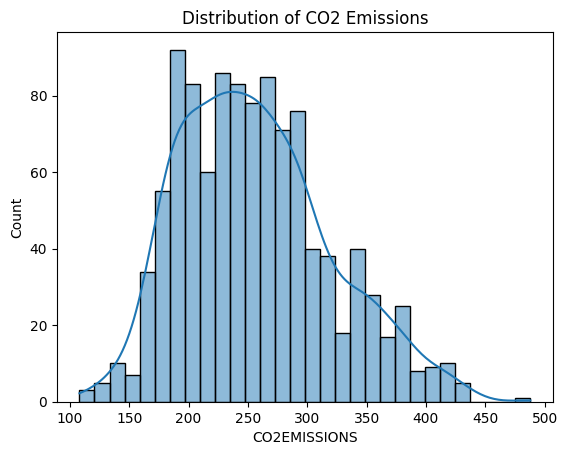

In [4]:
# Distribution of target
sns.histplot(data["CO2EMISSIONS"], bins=30, kde=True)
plt.title("Distribution of CO2 Emissions")
plt.show()

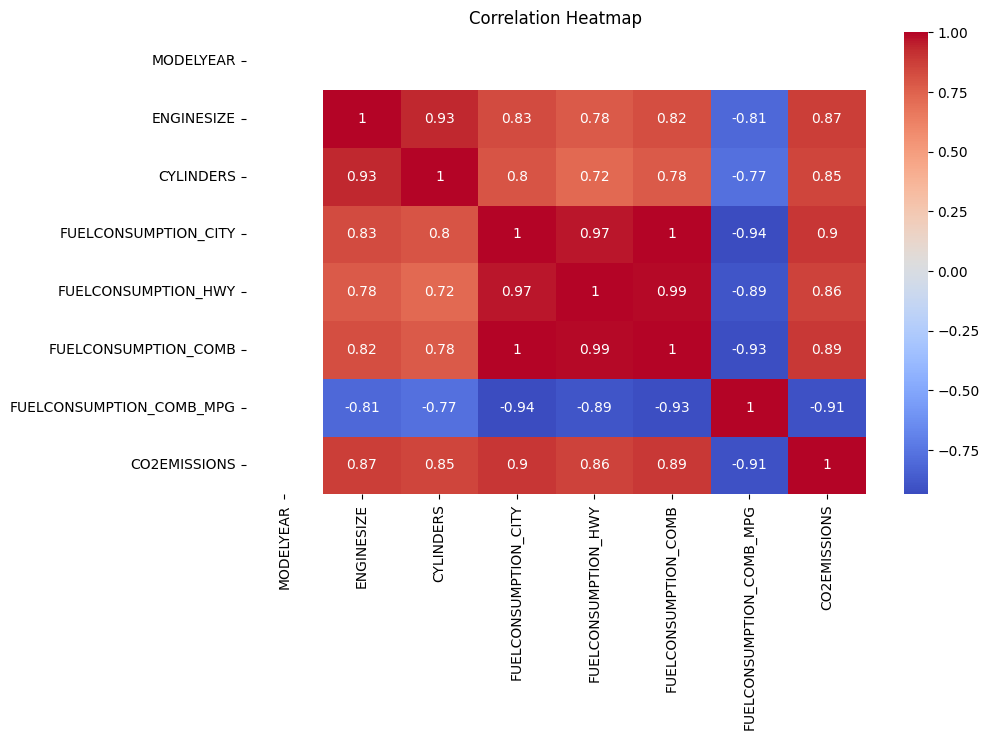

In [5]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# =========================
# 4. DROP LEAKAGE & NON-USEFUL COLUMNS
# =========================
drop_cols = [
    "MODEL",  # High cardinality, behaves like an ID
    "FUELCONSUMPTION_CITY",
    "FUELCONSUMPTION_HWY",
    "FUELCONSUMPTION_COMB",
    "FUELCONSUMPTION_COMB_MPG"
]
data = data.drop(columns=drop_cols)


In [10]:
# =========================
# 5. FEATURE ENGINEERING
# =========================
# Separate target and features
y = data["CO2EMISSIONS"]
X = data.drop(columns=["CO2EMISSIONS"])

# Identify categorical & numeric columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Handle rare categories (merge small ones into 'OTHER')
for col in cat_cols:
    value_counts = X[col].value_counts()
    rare_values = value_counts[value_counts < 10].index
    X[col] = X[col].replace(rare_values, "OTHER")


In [11]:
# =========================
# 6. ENCODING + MODEL PIPELINE
# =========================
# OneHotEncode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), cat_cols)
    ],
    remainder="passthrough"
)

# Define models to compare
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [12]:

# =========================
# 7. TRAIN / EVALUATE MODELS
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    print(f"\n{name} Performance:")
    print(f" MAE: {mae:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" R²: {r2:.2f}")
    
# Compare results
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)



LinearRegression Performance:
 MAE: 15.10
 RMSE: 19.62
 R²: 0.91

RandomForest Performance:
 MAE: 12.07
 RMSE: 16.89
 R²: 0.93

GradientBoosting Performance:
 MAE: 14.93
 RMSE: 19.84
 R²: 0.90

Model Comparison:
               Model        MAE       RMSE        R2
0  LinearRegression  15.098186  19.615524  0.906947
1      RandomForest  12.066203  16.892167  0.930992
2  GradientBoosting  14.933486  19.840342  0.904802


In [13]:
# =========================
# 8. PICK BEST MODEL & SAVE
# =========================
best_model_name = results_df.sort_values(by="R2", ascending=False).iloc[0]["Model"]
print(f"\nBest model based on R²: {best_model_name}")

best_model = models[best_model_name]
best_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", best_model)
])
best_pipe.fit(X_train, y_train)

joblib.dump(best_pipe, "best_co2_model.pkl")
print("Best model saved as best_co2_model.pkl")



Best model based on R²: RandomForest
Best model saved as best_co2_model.pkl



Sample Predictions:
    Actual   Predicted
0     304  272.051333
1     221  233.105167
2     294  257.361417
3     221  227.895048
4     207  206.246250
5     246  231.575992
6     259  265.385917
7     310  305.994750
8     310  305.172440
9     264  256.964667


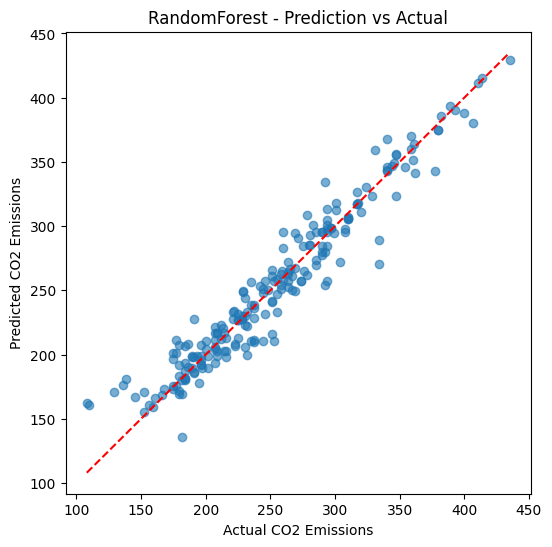

In [14]:
# =========================
# 9. PREDICTION CHECK
# =========================
y_pred_best = best_pipe.predict(X_test)

# Show first 10 predictions vs actual
pred_df = pd.DataFrame({"Actual": y_test.values[:10], "Predicted": y_pred_best[:10]})
print("\nSample Predictions:\n", pred_df)

# Scatter plot of actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.title(f"{best_model_name} - Prediction vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()
